#TODO LIST

1. Pick a dataset
2. Download the dataset
3. Import the Dataset using PyTorch
4. Explore the Dataset
5. Prepare the Dataset for Training

### Download the Dataset

### Using opendatasets and download the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [15]:
!pip install opendatasets --upgrade --quiet


In [14]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/'

In [16]:
import opendatasets as od

In [11]:
import os
import shutil

In [17]:
if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [18]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aminnadimpk
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:01<00:00, 191MB/s]


In [19]:
data_dir = './flowers-recognition/flowers'


In [20]:
import os


In [21]:
os.listdir(data_dir)


['sunflower', 'rose', 'daisy', 'dandelion', 'tulip']

In [22]:
['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']


['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [23]:
import shutil


##shutil.rmtree(data_dir + '/flowers')


In [24]:
os.listdir(data_dir)

['sunflower', 'rose', 'daisy', 'dandelion', 'tulip']

In [25]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))


sunflower : 733
rose : 784
daisy : 764
dandelion : 1052
tulip : 984


## Import the Dataset Into PyTorch
Use the ImageFolder class from torchvision.

In [26]:
from torchvision.datasets import ImageFolder


In [27]:
dataset = ImageFolder(data_dir)


In [28]:
len(dataset)


4317

In [29]:
dataset[0]


(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FE540D23950>, 0)

In [30]:
dataset.classes


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

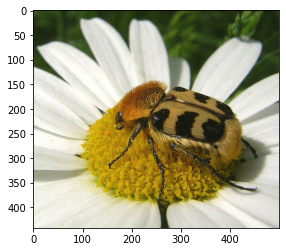

In [32]:
img, label = dataset[120]
plt.imshow(img)

In [33]:
import torchvision.transforms as tt


In [34]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

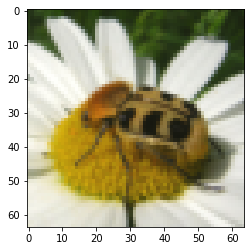

In [35]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))


In [36]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [37]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)


(3886, 431)

In [38]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


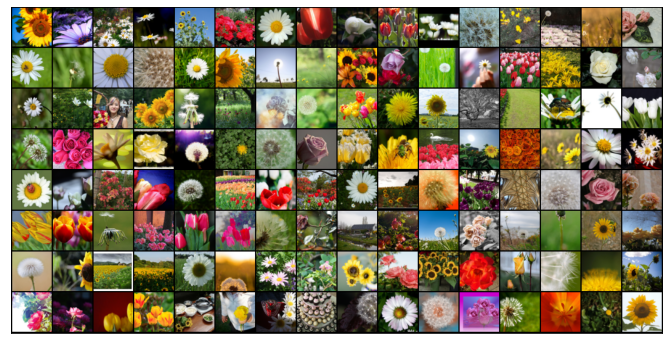

In [40]:
show_batch(train_dl)

## GPU Utilities


## Utilities & Functions

In [41]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [42]:
torch.cuda.is_available()


True

In [43]:
device = get_default_device()


In [44]:
device


device(type='cuda')

In [45]:
img, label = dataset[0]


In [46]:
img.device


device(type='cpu')

In [47]:
img_gpu = to_device(img, device)
img_gpu.device


device(type='cuda', index=0)

In [48]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


# Model and Training Utilties


In [49]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



In [50]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# MODEL

In [51]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [52]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [53]:
model.conv1[0].weight.device


device(type='cuda', index=0)

##Pass one batch of input tensor through the model.



In [54]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


preds.shape torch.Size([128, 5])


#TRAINING

In [55]:
history = [evaluate(model, valid_dl)]
history


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.2557762563228607, 'val_loss': 1.6086777448654175}]

In [56]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4755, val_loss: 1.5964, val_acc: 0.3167
Epoch [1], train_loss: 0.9631, val_loss: 0.9502, val_acc: 0.6370
Epoch [2], train_loss: 0.8820, val_loss: 0.8255, val_acc: 0.7018
Epoch [3], train_loss: 0.7918, val_loss: 0.9665, val_acc: 0.6683
Epoch [4], train_loss: 0.7212, val_loss: 0.7459, val_acc: 0.7437


In [57]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8406, val_loss: 0.8954, val_acc: 0.6814
Epoch [1], train_loss: 0.6569, val_loss: 0.6729, val_acc: 0.7568
Epoch [2], train_loss: 0.5958, val_loss: 0.7537, val_acc: 0.7467
Epoch [3], train_loss: 0.5487, val_loss: 0.6642, val_acc: 0.7540
Epoch [4], train_loss: 0.5305, val_loss: 0.7913, val_acc: 0.7062


In [58]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4080, val_loss: 0.5594, val_acc: 0.7959
Epoch [1], train_loss: 0.3550, val_loss: 0.5277, val_acc: 0.8129
Epoch [2], train_loss: 0.3286, val_loss: 0.5460, val_acc: 0.8216
Epoch [3], train_loss: 0.3111, val_loss: 0.5409, val_acc: 0.8221
Epoch [4], train_loss: 0.2975, val_loss: 0.5378, val_acc: 0.8182


In [71]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.SGD)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2786, val_loss: 0.5416, val_acc: 0.8135
Epoch [1], train_loss: 0.2800, val_loss: 0.5171, val_acc: 0.8154
Epoch [2], train_loss: 0.2803, val_loss: 0.5412, val_acc: 0.8252
Epoch [3], train_loss: 0.2727, val_loss: 0.5304, val_acc: 0.8174
Epoch [4], train_loss: 0.2910, val_loss: 0.5196, val_acc: 0.8280


In [72]:
history += fit(5, 0.0001, model, train_dl, valid_dl)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2797, val_loss: 0.5361, val_acc: 0.8154
Epoch [1], train_loss: 0.2826, val_loss: 0.5331, val_acc: 0.8202
Epoch [2], train_loss: 0.2755, val_loss: 0.5380, val_acc: 0.8174
Epoch [3], train_loss: 0.2787, val_loss: 0.5351, val_acc: 0.8207
Epoch [4], train_loss: 0.2772, val_loss: 0.5332, val_acc: 0.8280


In [60]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


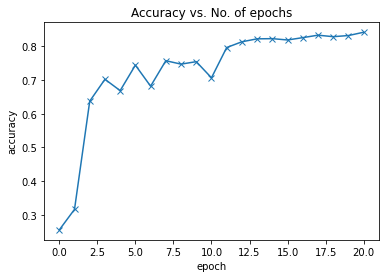

In [61]:
plot_accuracies(history)


In [62]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


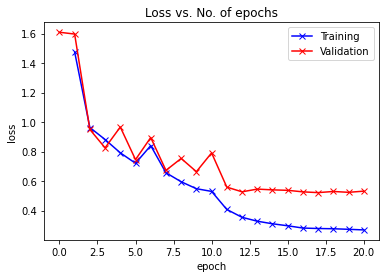

In [63]:
plot_losses(history)

# RECORD THE RESULT

In [64]:
history[-1]

{'train_loss': 0.2695172131061554,
 'val_acc': 0.8411319851875305,
 'val_loss': 0.5321536064147949}

# TEST WITH INDIVIDUAL IMAGES

In [65]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]


In [66]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)


In [67]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')


Target: daisy
Prediction: daisy


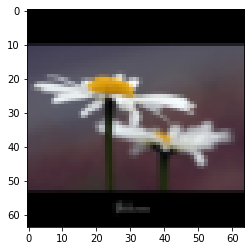

In [68]:
show_image_prediction(*valid_ds[100])


Target: tulip
Prediction: tulip


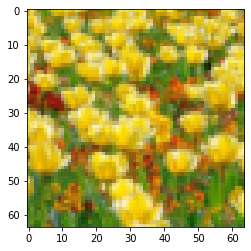

In [69]:
show_image_prediction(*valid_ds[300])

Target: daisy
Prediction: dandelion


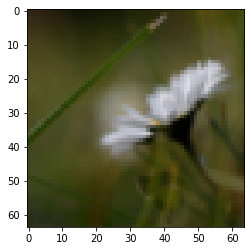

In [70]:
show_image_prediction(*valid_ds[12])
